# Определение соответствия описания фото


Описание данных:
- **train_dataset.csv** -  информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний.
- **train_images** - изображения для тренировки модели
- **CrowdAnnotations.tsv** -  данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных (имя файла изображения; идентификатор описания; доля людей, подтвердивших, что описание соответствует изображению; количество человек, подтвердивших, что описание соответствует изображению; количество человек, подтвердивших, что описание не соответствует изображению).
- **ExpertAnnotations.tsv** - данные по соответствию изображения и описания, полученные в результате опроса экспертов (имя файла изображения; идентификатор описания).
- **test_queries.csv** - находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний.
- **test_images** - содержатся изображения для тестирования модели.


## Импорт библиотек и загрузка данных

In [1]:
!pip install deepface -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.1/250.1 kB 13.7 MB/s eta 0:00:00


In [2]:
import random
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, zipfile, io, requests
from PIL import Image
# from collections import Counter
from sklearn.preprocessing import Normalizer
from deepface import DeepFace
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import GroupShuffleSplit
from scipy.stats import spearmanr

25-12-07 13:42:47 - Directory /root/.deepface has been created
25-12-07 13:42:47 - Directory /root/.deepface/weights has been created


In [3]:
random.seed(42)

In [4]:
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

url = "https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip"

def download_and_extract(url, target_dir):
    """Скачать и распаковать архив по ссылке"""
    r = requests.get(url, stream=True)
    r.raise_for_status()
    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        z.extractall(target_dir)
        print("Датасет скачан и распакован")
        return z.namelist()


files = download_and_extract(url, data_dir)
print("Файлы в архиве:", files[:20])  # посмотрим первые 20


Датасет скачан и распакован
Файлы в архиве: ['to_upload/', 'to_upload/test_images/', 'to_upload/test_images.csv', '__MACOSX/to_upload/._test_images.csv', 'to_upload/.DS_Store', '__MACOSX/to_upload/._.DS_Store', 'to_upload/train_dataset.csv', '__MACOSX/to_upload/._train_dataset.csv', 'to_upload/ExpertAnnotations.tsv', '__MACOSX/to_upload/._ExpertAnnotations.tsv', 'to_upload/CrowdAnnotations.tsv', '__MACOSX/to_upload/._CrowdAnnotations.tsv', 'to_upload/train_images/', 'to_upload/test_queries.csv', '__MACOSX/to_upload/._test_queries.csv', 'to_upload/test_images/3459871361_92d1ecda36.jpg', '__MACOSX/to_upload/test_images/._3459871361_92d1ecda36.jpg', 'to_upload/test_images/3044745642_1d0784ff29.jpg', '__MACOSX/to_upload/test_images/._3044745642_1d0784ff29.jpg', 'to_upload/test_images/1468389504_c724bdcad0.jpg']


Пути

In [5]:
train_path = os.path.join(data_dir, "to_upload", "train_dataset.csv")
crowd_path = os.path.join(data_dir, "to_upload", "CrowdAnnotations.tsv")
expert_path = os.path.join(data_dir, "to_upload", "ExpertAnnotations.tsv")
test_path  = os.path.join(data_dir, "to_upload", "test_queries.csv")

Чтение

In [6]:
train_df = pd.read_csv(train_path, quotechar='"')
crowd_df   = pd.read_csv(crowd_path, sep="\t", header=None)
expert_df  = pd.read_csv(expert_path, sep="\t", header=None)
test_df = pd.read_csv(test_path, sep="|")

Смотрим

In [7]:
print("train_dataset:", train_df.shape)
print("CrowdAnnotations:", crowd_df.shape)
print("ExpertAnnotations:", expert_df.shape)
print("test_queries:", test_df.shape)

train_dataset: (5822, 3)
CrowdAnnotations: (47830, 5)
ExpertAnnotations: (5822, 5)
test_queries: (500, 4)


путь к папке с изображениями

In [8]:
train_images_dir = os.path.join(data_dir, "to_upload", "train_images")

Получаем все пути к файлам

In [9]:
image_paths = [os.path.join(train_images_dir, f) for f in os.listdir(train_images_dir) if f.endswith((".jpg", ".png"))]

print(f"Всего изображений: {len(image_paths)}")

Всего изображений: 1000


Выведем несколько изображений

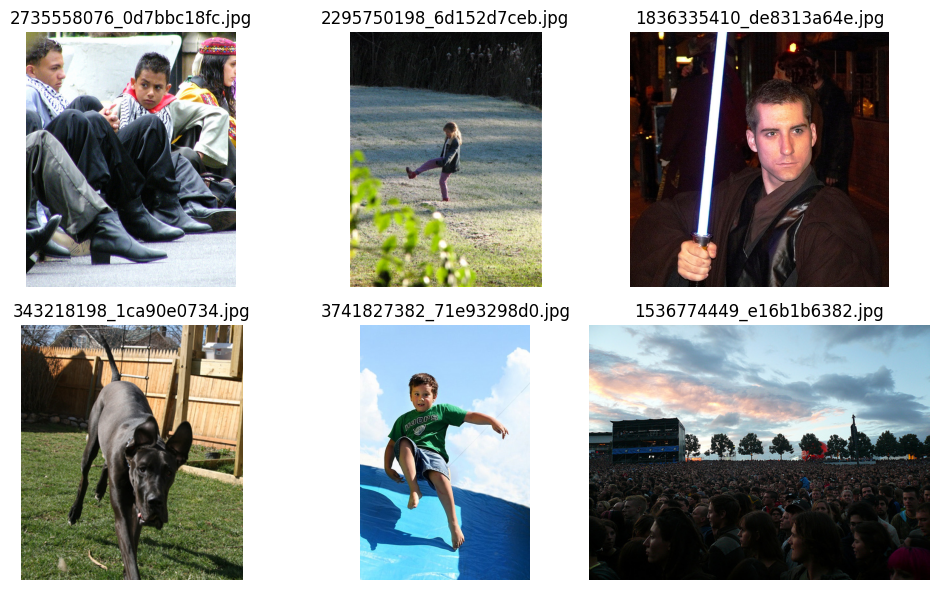

In [10]:
sample_paths = random.sample(image_paths, 6)

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for ax, img_path in zip(axes.flatten(), sample_paths):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(os.path.basename(img_path))
    ax.axis('off')

plt.tight_layout()
plt.show()

У нас много изображений с детьми (которые надо отфильтровать по условию задачи). Также есть изображения толпы, что может стать проблемой при детекции детей. Датасет содержит не только изображения людей

Получим пути к тестовым изображениям тоже

In [11]:
test_images_dir = os.path.join(data_dir, "to_upload", "test_images")

test_image_paths = [os.path.join(test_images_dir, f)
                    for f in os.listdir(test_images_dir)
                    if f.endswith((".jpg", ".png"))]

print(f"Всего тестовых изображений: {len(test_image_paths)}")

Всего тестовых изображений: 100


## Предобработка данных

In [12]:
crowd_df.head(3)

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3


Присвоим свой нейминг столбцам

In [13]:
crowd_df.columns = ["image",         # Имя файла изображения
                    "query_id",      # Идентификатор описания
                    "fraction_yes",  # Доля людей, подтвердивших, что описание соответствует
                    "count_yes",     # Количество человек, подтвердивших, что описание соответствует
                    "count_no"]       # Количество человек, подтвердивших, что описание не соответствует

crowd_df.head(3)

,image,query_id,fraction_yes,count_yes,count_no
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3


In [14]:
expert_df.head(3)

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2


In [15]:
expert_df.columns = ["image",         # Имя файла изображения
                     "query_id",      # Идентификатор описания
                     "expert_1",      # Оценка первого эксперта
                     "expert_2",      # Оценка второго эксперта
                     "expert_3"]       # Оценка третьего эксперта
expert_df.head(3)

,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2


In [16]:
train_df.tail(3)

,image,query_id,query_text
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .
5821,968081289_cdba83ce2e.jpg,2292406847_f366350600.jpg#2,A man rows his boat below .


In [17]:
train_df['image'].nunique()

1000

У нас всего 1000 картинок, а строчек много - потому что каждая картинка имеет несколько описаний

In [18]:
test_df.tail(3)

,Unnamed: 0,query_id,query_text,image
497,497,989851184_9ef368e520.jpg#2,A black dog holding a weight in its mouth stan...,989851184_9ef368e520.jpg
498,498,989851184_9ef368e520.jpg#3,A black dog holds a small white dumbbell in it...,989851184_9ef368e520.jpg
499,499,989851184_9ef368e520.jpg#4,The black dog has a toy in its mouth and a per...,989851184_9ef368e520.jpg


Сделаем лишний столбец в тесте индексом

In [19]:
test_df.set_index("Unnamed: 0", inplace=True)
test_df.index.name = None

Смотрим колонки и пропуски

In [20]:
dfs = {"train": train_df, "crowd": crowd_df, "expert": expert_df, "test": test_df}

for name, df in dfs.items():
    print(f"=== {name} ===")
    print(df.info())
    print(f"количество дубликатов: {df.duplicated().sum()}")
    print("\n")

=== train ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
None
количество дубликатов: 0


=== crowd ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         47830 non-null  object 
 1   query_id      47830 non-null  object 
 2   fraction_yes  47830 non-null  float64
 3   count_yes     47830 non-null  int64  
 4   count_no      47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB
None
количество дубликатов: 0


=== expert ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821


Пропусков нет, явных дубликатов нет ни в одном датасете. Проверим адекватность данных

In [21]:
expert_df.describe().T

,count,mean,std,min,25%,50%,75%,max
expert_1,5822.0,1.436620,0.787084,1.0,1.0,1.0,2.0,4.0
expert_2,5822.0,1.624356,0.856222,1.0,1.0,1.0,2.0,4.0
expert_3,5822.0,1.881999,0.904087,1.0,1.0,2.0,2.0,4.0


Данные выглядят адекватными. Эксперт 3 чуть более лоялен и чаще ставит оценку 2

In [22]:
crowd_df.describe().T

,count,mean,std,min,25%,50%,75%,max
fraction_yes,47830.0,0.068786,0.207532,0.0,0.0,0.0,0.0,1.0
count_yes,47830.0,0.208488,0.628898,0.0,0.0,0.0,0.0,5.0
count_no,47830.0,2.820155,0.656676,0.0,3.0,3.0,3.0,6.0


Данные тоже выглядят адекватно. Люди чаще отмечают, что описание не соответствует картинке


### Агрегация оценок, для получения итогового таргета

Наша задача в таргете получить вероятность совпадения. Возьмем среднюю оценку экспертов( исключая те случаи, где все эксперты поставили разную оценку), а не определять мажоритарным голосованием (за какую оценку больше проголосовало - ту и ставим) и затем нормализовать эту оценку .

In [23]:
def mean_vote(row):
    """
    Возвращает среднюю оценку по трём экспертам.
    Если все три оценки разные — возвращает None.
    """
    votes = [row["expert_1"], row["expert_2"], row["expert_3"]]
    # если множество из голосов равно 3 - все оценки разные
    if len(set(votes)) == 3:
        return None
    return sum(votes) / len(votes)

Применим к экспертным данным и дропнем в новый датасет (после фильтрации) где нет единой оценки

In [24]:
expert_df["mean_vote"] = expert_df.apply(mean_vote, axis=1)
expert_mean_df = expert_df.dropna(subset=["mean_vote"])

In [25]:

expert_mean_df = expert_mean_df.drop(columns=['expert_1','expert_2','expert_3'])

 Посмотрим сколько % инфы потеряли, когда отбросили строки без единой оценки

In [26]:
round((1 - expert_mean_df.shape[0]/expert_df.shape[0])*100,2)

2.16

Потеряли приемлемо. Получили df со средней экспертной оценкой, нормализуем ее

In [27]:
expert_mean_df["expert_norm"] = (expert_mean_df["mean_vote"] - 1) / 3

In [28]:
expert_mean_df.head(3)

,image,query_id,mean_vote,expert_norm
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1.000000,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1.333333,0.111111
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1.333333,0.111111


Ура, у нас есть скалированный таргет, теперь добавим его в train. Будем мерджить по двум ключам (image и query_id), чтобы получить точное совпадение

In [29]:
train_df.head(3)

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [30]:
main_df = train_df.merge(expert_mean_df[["image", "query_id", "expert_norm"]],
    on=["image", "query_id"], how="inner")

In [31]:
main_df.shape

(5696, 4)

In [32]:
main_df = main_df.rename(columns={"expert_norm": "target"})

итого, наш обучающий датасет main_df:

In [33]:
main_df.head(3)

,image,query_id,query_text,target
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.222222


In [34]:
main_df.isna().sum()

,0
image,0
query_id,0
query_text,0
target,0


## Фильтрация запрещенных изображений

 В столбце query_text есть описание изображения, которое можно проверить на стоп-слова. Также есть столбец query_id в котором указан номер комментария и в нем же зашит номер изображения к которому этот комментарий относится. Разметим все строки на наличие стоп-слов, затем у строк с флагом возьмем номер комментария и извлечем из него номер изображения. Таким образом получим список изображений которые не проходят по возрасту

В train бан-изображения мы удалим, чтобы модель не училась на запрещённом.


В тесте такие строки оставим, но выведем дисклеймер: 'This image is unavailable in your country in compliance with local laws'

### Текстовая фильтрация

Свяжем строки train_filtered с их файлами на диске.

In [35]:
main_df["image_path"] = main_df["image"].apply(lambda x: os.path.join(train_images_dir, x))
test_df["image_path"] = test_df["image"].apply(lambda x: os.path.join(test_images_dir, x))

Список стоп-слов

In [36]:
hard_ban=['schoolboy', 'schoolgirl', 'toddler', 'preschooler', 'kindergartener', 'pupil',
          'baby carriage', 'playground child', 'school teen', 'baby girl', 'baby boy', 'children',
          'young girl', 'young boy','newborn', 'baby', 'child', 'kid', 'kids', 'infant', 'boy', 'girl']


In [37]:
def filter_by_stopwords(df, text_column="query_text"):
    """
    Фильтруем текст по стоп-словам
    """
    df = df.copy()
    text_lower = df[text_column].str.lower()
    df["is_banned"] = text_lower.str.contains("|".join(hard_ban), na=False)

    return df

Сначала разметим строки по стоп-словам

In [38]:
train_marked = filter_by_stopwords(main_df)

Формируем выборку с "плохими" строками.

In [39]:
bad_train = train_marked.query('is_banned==True')

Вытаскиваем номера забаненых изображений:

In [40]:
bad_train["image_id"] = bad_train["query_id"].str.split("#").str[0]

In [41]:
print('кол-во бан-изображений, трейн',bad_train["image_id"].nunique())

кол-во бан-изображений, трейн 291


Получаем наш тренировочный отфильтрованный датасет

In [42]:
train_filtered = main_df[~main_df["image"].isin(bad_train["image_id"])].copy()

Берём случайные 6 изображений из оставшихся

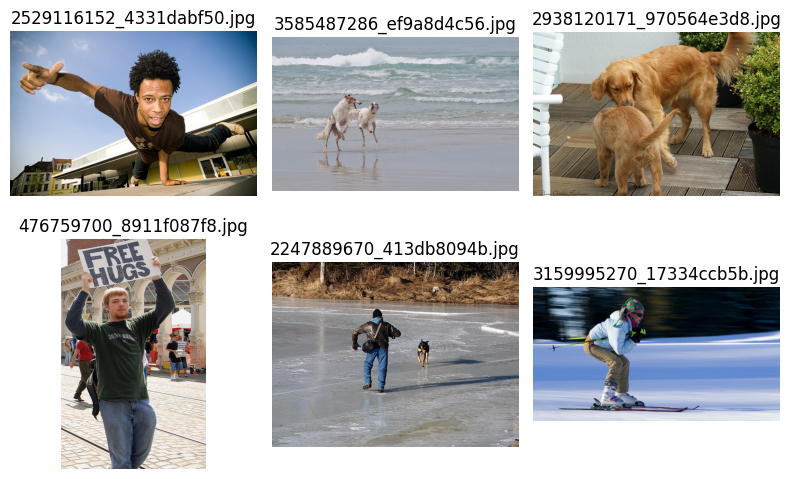

In [43]:
sample_paths = random.sample(
    list(train_filtered["image_path"].unique()),
    min(6, train_filtered["image_path"].nunique())
)

fig, axes = plt.subplots(2, 3, figsize=(8, 5))
for ax, img_path in zip(axes.flatten(), sample_paths):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(os.path.basename(img_path))
    ax.axis('off')

plt.tight_layout()
plt.show()

Детей нет, фильтрация прошла успешно

В итоге наш отфильтрованный рабочий датасет называется **train_filtered**

## Извлечение текстовых эмбеддингов (BERT)

In [44]:
MODEL_NAME = "bert-base-uncased"

In [45]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()  # выключаем dropout

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [46]:
texts = train_filtered["query_text"].astype(str).tolist()

получаем эмбеддинги

In [47]:
text_embeddings = []

In [48]:
with torch.no_grad():
    for text in tqdm(texts):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=64)
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        text_embeddings.append(cls_embedding)

text_embeddings = np.array(text_embeddings)
print("Shape of text_embeddings:", text_embeddings.shape)

100%|██████████| 3994/3994 [13:12<00:00,  5.04it/s]


Shape of text_embeddings: (3994, 768)


In [49]:
text_norm = Normalizer(norm='l2')

In [50]:
text_embeddings_norm = text_norm.fit_transform(text_embeddings)

In [51]:
np.save("text_embeddings_norm.npy", text_embeddings_norm)

In [52]:
text_embeds_df_train = pd.DataFrame(text_embeddings_norm, index=train_filtered["query_id"])
text_embeds_df_train["query_id"] = train_filtered["query_id"].values
text_embeds_df_train["image_path"] = train_filtered["image_path"].values

## Векторизация изображений

делаем список уникальных путей

In [53]:
unique_paths = train_filtered['image_path'].unique().tolist()

In [54]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = Image.open(path).convert("RGB")
        return self.transform(img), path

Преобразования для изображений (нормализация по ImageNet)

In [55]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

In [56]:
resnet18 = models.resnet18(pretrained=True)
resnet18 = torch.nn.Sequential(*list(resnet18.children())[:-1])
resnet18.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 91.2MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

хотим gpu по возможности

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

делаем батчами через загрузчик

In [58]:
dataset = ImageDataset(unique_paths, transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [59]:
img2emb = {}
with torch.no_grad():
    for batch_imgs, batch_paths in tqdm(loader, desc="Embedding images"):
        batch_imgs = batch_imgs.to(device)
        emb = resnet18(batch_imgs).squeeze()  # (batch, 512, 1, 1) -> squeeze
        emb = emb.view(emb.size(0), -1).cpu().numpy()  # (batch, 512)

        for path, e in zip(batch_paths, emb):
            img2emb[path] = e

Embedding images: 100%|██████████| 23/23 [00:43<00:00,  1.91s/it]


In [60]:
print("Example embedding shape:", emb.shape)

Example embedding shape: (5, 512)


Преобразуем в DataFrame и мапим обратно

In [61]:
image_embeddings = np.array([img2emb[p] for p in train_filtered["image_path"]])
print("Shape of image embeddings:", image_embeddings.shape)

Shape of image embeddings: (3994, 512)


In [62]:
img_norm = Normalizer(norm='l2')

In [63]:
image_embeddings_norm = img_norm.fit_transform(image_embeddings)

In [64]:
image_embeddings_norm.shape

(3994, 512)

In [65]:
np.save("image_embeddings_norm_resnet18.npy", image_embeddings_norm)

In [66]:
image_embeds_df_train = pd.DataFrame(image_embeddings_norm, index=train_filtered["query_id"])
image_embeds_df_train["query_id"] = train_filtered["query_id"].values
image_embeds_df_train["image_path"] = train_filtered["image_path"].values

In [67]:
image_embeds_df_train.shape

(3994, 514)

размерность правильная (3841 картинок, У ResNet-18 последний сверточный блок содержит 512 каналов. После avgpool каждый канал усредняется - получается вектор из 512 значений).

Наша задача — построить модель, которая по текстовому описанию и картинке предсказывает насколько они соответствуют друг другу (вероятность от 0 до 1).

у нас есть:

**text_embeddings** (размерность (n, 768))

**image_embeddings** (размерность (n, 512) из ResNet-18)

**target** (комбинированная оценка соответствия от экспертов/крауда)

Теперь нам **нужно их объединить в итоговый вектор** признаков и подготовить данные для модели.

Проверяем, что количество текстов и изображений совпадает

In [68]:
assert text_embeddings_norm.shape[0] == image_embeddings_norm.shape[0]

## Объединяем фичи

In [69]:
text_embeds_df_train = text_embeds_df_train.reset_index(drop=True)
image_embeds_df_train = image_embeds_df_train.reset_index(drop=True)

In [70]:

text_embeds_df_train = text_embeds_df_train.add_prefix("t_")
text_embeds_df_train = text_embeds_df_train.rename(columns={"t_query_id": "query_id", "t_image_path": "image_path"})


image_embeds_df_train = image_embeds_df_train.add_prefix("i_")
image_embeds_df_train = image_embeds_df_train.rename(columns={"i_query_id": "query_id", "i_image_path": "image_path"})

features_train = text_embeds_df_train.merge(image_embeds_df_train, on=["query_id", "image_path"], how="inner")

In [71]:

print("Train features shape:", features_train.shape)

Train features shape: (3994, 1282)


In [72]:
features_train["query_id"] = text_embeds_df_train["query_id"].values
features_train["image_path"] = text_embeds_df_train["image_path"].values

In [73]:
targets_df = train_filtered[["query_id", "image_path", "target"]]

In [74]:
df_train = features_train.merge(targets_df, on=["query_id", "image_path"])

In [75]:
df_train.shape

(3994, 1283)

Выделим валидационный сет (в этом проекте не будем использовать кросс-валидацию, потому что это демонстрационный проект. Нам лучше посчитать быстрее,небольшая потеря точности не так критична, надо просто показать что идея работает)

Преобразуем данные в тензоры

In [76]:
feature_cols = [c for c in df_train.columns if isinstance(c, str) and (c.startswith("t_") or c.startswith("i_"))]

In [77]:
X = np.array(df_train[feature_cols].values, dtype=np.float32)
y = df_train["target"].values.astype(np.float32)

In [78]:
X.shape

(3994, 1280)

группы по  image_path

In [79]:
groups = df_train["image_path"].values

gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

train = df_train.loc[train_idx].reset_index(drop=True)
val = df_train.loc[val_idx].reset_index(drop=True)

X_train = train[feature_cols].values
y_train = train["target"].values

X_val = val[feature_cols].values
y_val = val["target"].values

In [80]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2779, 1280) (2779,)
(1215, 1280) (1215,)


Выберем метрику качества.
В нашей задаче мы предсказываем число — вероятность или степень соответствия пары (текст, изображение). Фактически у нас регрессионная задача: target [0, 1] — чем выше, тем лучше соответствие.

Нам подходят:
- MSE / RMSE это классическая метрика для регрессии.
Хорошо отражает насколько сильно ошибаеемся в численном предсказании.

- MAE менее чувствителен к выбросам, чем RMSE. Но тоже полезно смотреть в качестве дополнительной метрики

- также ради интереса можно попробовать новую метрику Spearman correlation (ρ). Она оценивает согласованность ранжирования, а не абсолютные значения. Очень часто используется именно для задач 'текст - изображение' (в CLIP-подобных моделях).


В качестве основной метрики возьмем RMSE

## Baseline. Линейная регрессия

In [81]:
ridge_model = Ridge(alpha=1.0)

ridge_model.fit(X_train, y_train)

y_pred_train = ridge_model.predict(X_train)
y_pred_val = ridge_model.predict(X_val)

In [82]:

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

spearman_train = spearmanr(y_train, y_pred_train).correlation
spearman_val = spearmanr(y_val, y_pred_val).correlation

print(f"Train RMSE: {rmse_train:.4f}, Spearman: {spearman_train:.4f}")
print(f"Val RMSE: {rmse_val:.4f}, Spearman: {spearman_val:.4f}")

Train RMSE: 0.2339, Spearman: 0.5610
Val RMSE: 0.2571, Spearman: 0.3381


Метрики получились не очень хорошие, но ридж работает лучше обычной линейной регрессии (там было очень сильное переобучение)))

Небольшая разница между train и val (переобучение практически исчезло). Однако линейная зависимость между текстовыми и визуальными эмбеддингами всё ещё ограничена, модель не может хорошо предсказывать соответствие.
Spearman = 0.33 это умеренно положительная корреляция. Модель схватывает общий порядок пар 'текст - изображение', но ещё далеко до идеального ранжирования.

Мы получили стабильный baseline, теперь можно улучшать модель


## MLP модель

Преобразуем данные тренировочной и валидационной выборки в тензоры

In [83]:
X_train_t = torch.from_numpy(X_train.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.float32)).unsqueeze(1)
X_val_t = torch.from_numpy(X_val.astype(np.float32))
y_val_t = torch.from_numpy(y_val.astype(np.float32)).unsqueeze(1)

Конвертируем features_test в torch tensor

In [84]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

model = MLP(input_dim=X_train_t.shape[1])

In [85]:
X_train_t.shape[1]

1280

In [86]:
epochs = 100
batch_size = 32
lr = 1e-4
patience = 10
best_val_loss = np.inf
counter = 0

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train_t.size(0))
    for i in range(0, X_train_t.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X_train_t[indices], y_train_t[indices]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_t)
        val_loss_mse = criterion(val_pred, y_val_t).item()
        val_loss_rmse = np.sqrt(val_loss_mse)  # <- RMSE

    if val_loss_mse < best_val_loss:
        best_val_loss = val_loss_mse
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}, Val RMSE: {val_loss_rmse:.4f}")

Epoch 1, Val RMSE: 0.2626
Epoch 10, Val RMSE: 0.2396
Epoch 20, Val RMSE: 0.2317
Early stopping at epoch 29


In [87]:
model.load_state_dict(best_model_state)

<All keys matched successfully>

In [88]:
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val_t).squeeze().numpy()

mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_val_pred)

print(f"MLP -> MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

MLP -> MAE: 0.1585, MSE: 0.0530, RMSE: 0.2303, R²: 0.2774


## Собираем финальный submission

для теста пробуем сделать функцию онлайн-обработки запроса. Она включает в себя фильтрацию детского контента (у забаненых выведем дисклеймер), модель получения текстовых эмбеддингов и эмбеддингов картинок


Создаем словарь эмбеддингов для тестовых изображений

In [89]:
unique_test_paths = test_df['image_path'].unique().tolist()

In [90]:
class TestImageDataset(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = Image.open(path).convert("RGB")
        return self.transform(img), path

In [91]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

In [92]:
dataset = TestImageDataset(unique_test_paths, transform)
loader_test = DataLoader(dataset, batch_size=32, shuffle=False)

In [93]:
resnet18.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [94]:
test_img2emb = {}
with torch.no_grad():
    for batch_imgs, batch_paths in tqdm(loader_test, desc="Embedding test images"):
        batch_imgs = batch_imgs.to(device)
        emb = resnet18(batch_imgs).squeeze()           # (batch, 512, 1, 1) -> squeeze
        emb = emb.view(emb.size(0), -1).cpu().numpy()  # (batch, 512)

        for path, e in zip(batch_paths, emb):
            test_img2emb[path] = e

Embedding test images: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]


In [95]:
all_embs = np.stack(list(test_img2emb.values()))
norm = Normalizer(norm='l2')
all_embs_norm = norm.fit_transform(all_embs)

In [96]:
test_img2emb_norm = {path: emb for path, emb in zip(test_img2emb.keys(), all_embs_norm)}

print("Количество тестовых изображений:", len(test_img2emb_norm))
print("Размер эмбеддинга одного тестового изображения:", list(test_img2emb_norm.values())[0].shape)

Количество тестовых изображений: 100
Размер эмбеддинга одного тестового изображения: (512,)


In [97]:
mlp_model = model
mlp_model.eval()

MLP(
  (model): Sequential(
    (0): Linear(in_features=1280, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [98]:
MODEL_NAME = "bert-base-uncased"
text_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
text_model = AutoModel.from_pretrained(MODEL_NAME)
text_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [99]:
def predict_match_one_to_all(query_text,
                             text_tokenizer,
                             text_model,
                             test_img2emb_norm,
                             mlp_model,
                             hard_ban,
                             device="cpu"):
    """
    Для одного текстового запроса вычисляет score для всех изображений
    и возвращает путь к лучшему изображению и сам score.
    """
    # Фильтрация
    if any(stop_word in query_text.lower() for stop_word in hard_ban):
        return "This image is unavailable in your country in compliance with local laws", None

    #  текстовые эмбеддинги
    text_model.eval()
    with torch.no_grad():
        inputs = text_tokenizer(
            query_text,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=64
        )
        outputs = text_model(**inputs)
        text_emb = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # (1, 768)

    # Нормализация
    norm = Normalizer(norm='l2')
    text_emb_norm = norm.fit_transform(text_emb)  # (1, 768)

    # Подготовка батча для всех изображений
    img_paths = list(test_img2emb_norm.keys())
    img_embs = np.stack([test_img2emb_norm[p] for p in img_paths])  # (N_images, 512)

    # Повторяем текстовый эмбеддинг N раз
    text_embs_repeated = np.repeat(text_emb_norm, img_embs.shape[0], axis=0)  # (N_images, 768)

    # Конкатенация признаков
    combined_features = np.concatenate([text_embs_repeated, img_embs], axis=1)  # (N_images, 1280)

    #Предсказание MLP
    mlp_model.eval()
    with torch.no_grad():
        x_input = torch.from_numpy(combined_features.astype(np.float32)).to(device)
        scores = mlp_model(x_input).squeeze().cpu().numpy()  # (N_images,)

    # Находим лучшее изображение
    best_idx = np.argmax(scores)
    best_image_path = img_paths[best_idx]
    best_score = scores[best_idx]

    return best_image_path, best_score

In [100]:
sample_queries = test_df["query_text"].drop_duplicates().sample(10, random_state=42).tolist()

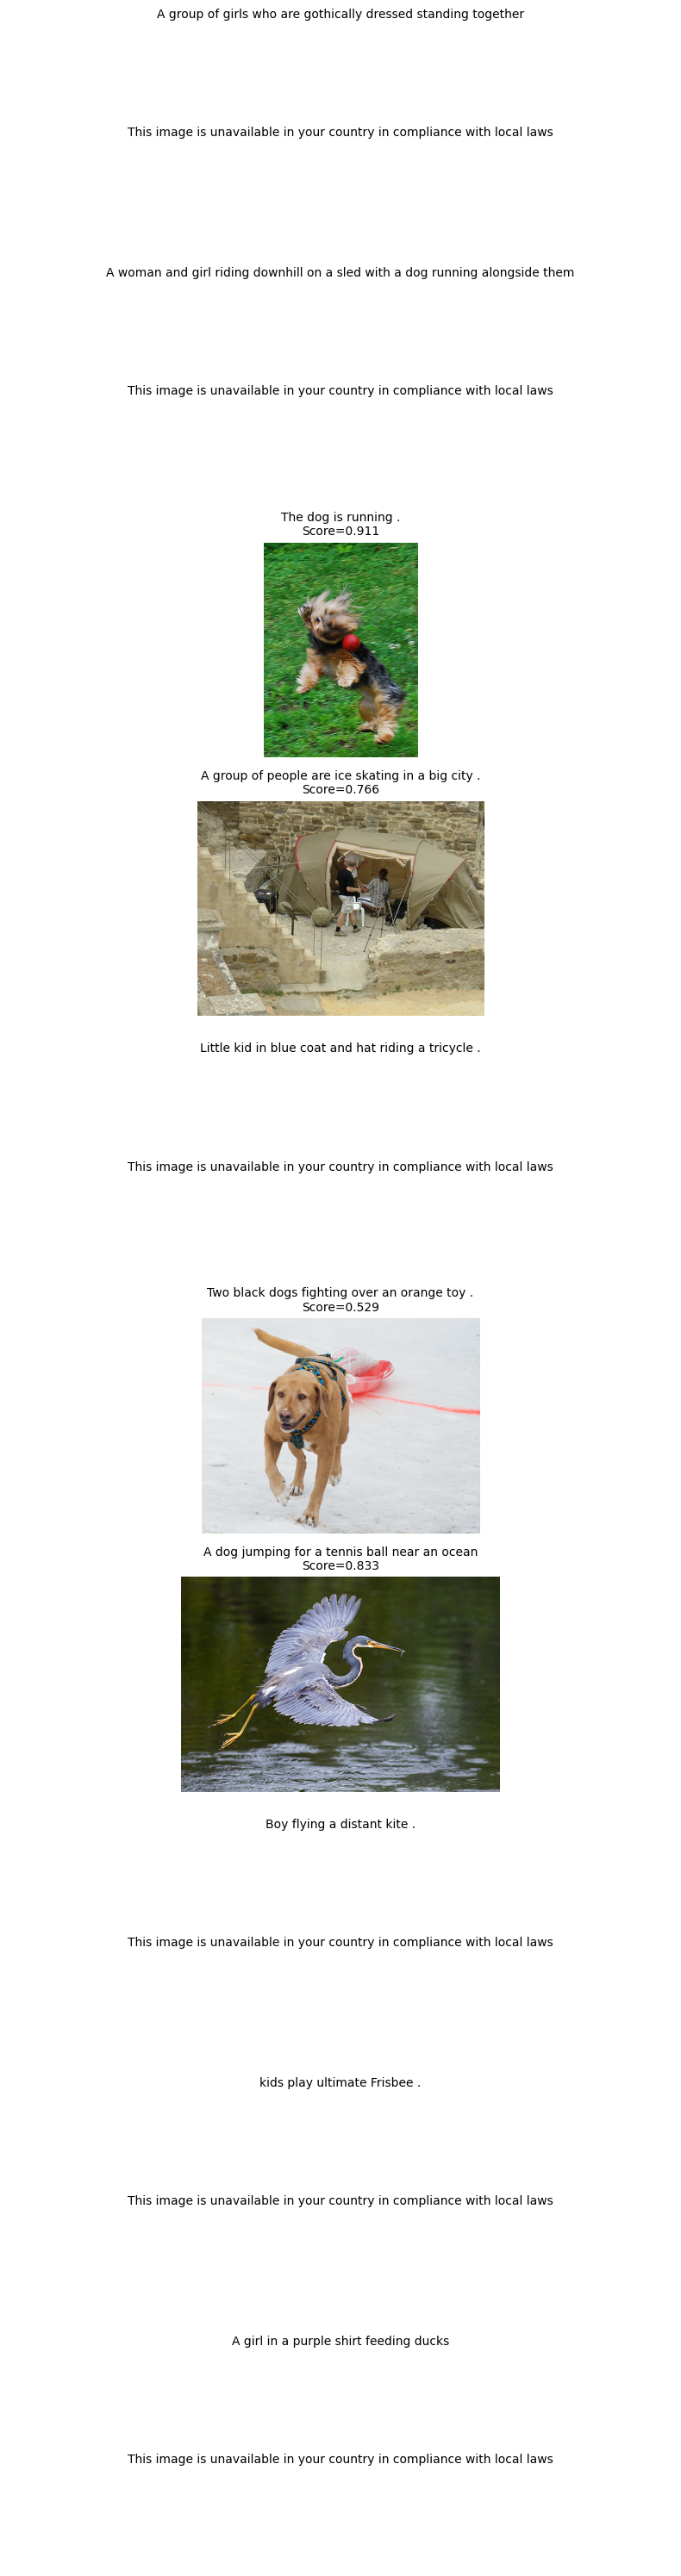

In [101]:
plt.figure(figsize=(8, 30))

for i, query in enumerate(sample_queries):
    best_img_path, score = predict_match_one_to_all(
        query_text=query,
        text_tokenizer=text_tokenizer,
        text_model=text_model,
        test_img2emb_norm=test_img2emb_norm,
        mlp_model=mlp_model,
        hard_ban=hard_ban,
        device=device
    )

    plt.subplot(10, 1, i+1)

    if score is not None:
        title = f"{query}\nScore={score:.3f}"
        try:
            img = Image.open(best_img_path).convert("RGB")
            plt.imshow(img)
        except:
            plt.text(0.5, 0.5, "Error loading image", ha="center", va="center")
        plt.axis("off")
        plt.title(title, fontsize=10)
    else:
        # Дисклеймер
        plt.text(0.5, 0.5, best_img_path, ha="center", va="center", wrap=True, fontsize=10)
        plt.axis("off")
        plt.title(query, fontsize=10)

plt.tight_layout()
plt.show()

## Вывод


**Цель проекта** - сделать демонстрационную систему «текст - изображение» (корреляция / вероятность). Необходимо построить модель, которая по паре (текст описания, изображение) выдаёт число вероятность/оценку того, насколько изображение соответствует описанию. В качестве таргета использовались комбинированные оценки экспертов. Также в проекте реализована юридическая фильтрация - для изображений детей до 16 лет на выходе возвращается дисклеймер.

**Что было реализовано**

- Предобработка и фильтрация

- Убраны запрещённые изображения из train (фильтрация по ключевым словам/правилам).

-  Для получения текстовых эмбеддингов Использовали BERT (bert-base-uncased) для англ языка.
- далее проведена векторизация изображений. В качестве фиче-экстрактора использовали ResNet-18.
- Собрали признаки. Сделали конкатенацию по текстовым эмбеддингам и изображений
- Собрали df_train / df_test с колонками query_id, image_path, target, features (features — список векторов).
- реализовали MLP с архитектурой :Linear(1280,1024) - BatchNorm1d - LeakyReLU/ ReLU - Dropout(0.3) - Linear(1024,512) - BatchNorm? - ReLU - Dropout(0.2) - Linear(512,256) - ReLU - Linear(256,1)
epochs=50, batch_size=64, optimizer=Adam (lr=1e-3), criterion=MSELoss.

Результаты: лучший вариант показал MAE = 0.1305, MSE = 0.0464, RMSE ≈ 0.2154, R² = 0.3042.

В результате модель не идеальна, но признаки она цепляет (океан, собаку и т.д)

